In [1]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# Overview

Time series forecasting is a large and complicated arena - opportunities for mistakes abound. That said, we will try to touch on some of the core points to keep in mind when engaging in such modeling. These points include:
- basic considerations for temporal data
- variable relationships
- feature engineering
- predictive model validation

Rob Hyndman has written a nice book on time series forecasting (albeit with examples in R), which you can find [here](https://otexts.com/fpp2/).

# 0. Get Data

We will be using free data from a website called QuantQuote. This dataset contains daily pricing data for all S&P 500 members as of August 2013, which is where the dataset ends. For each member, the data begins when that stock entered the index. We can programmatically download and extract it.

In [3]:
def get_data(data_url):
    with requests.get(data_url) as r:

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall()

In [4]:
data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

In [5]:
get_data(data_url=data_url)

In [6]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [7]:
len(os.listdir(data_dir))

500

In [8]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [9]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

In [10]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [11]:
aapl_df = get_df("table_aapl.csv")

In [12]:
aapl_df.head()

,date,open,high,low_price,close,volume
date,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


# 1. Exploratory Analysis

Gaining an understanding of your data is key; a big part of this is data visualization. We will also transform our data - smoothing, rescaling, and aggregating it - to get a better sense of what is driving it.

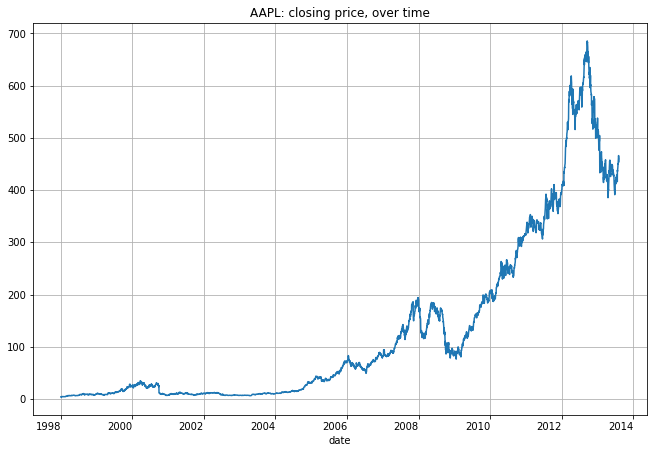

In [13]:
ax = aapl_df.close.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: closing price, over time")

### **Unit Root**

A real treatment of this concept is outside of our scope today, but you can read more about it [here](https://en.wikipedia.org/wiki/Unit_root) or [here](https://faculty.chicagobooth.edu/ruey.tsay/teaching/uts/lec11-08.pdf). For now, I'll go ahead and mention the following ...

Many statistical models require the assumption of certain distributional properties in the data. A key assumption is that of [*stationarity*](https://en.wikipedia.org/wiki/Stationary_process), which (among other things) means that the _mean_ and _variance_ of the data do not change over time.

If you are looking at the original and not relative-change values of your data, the data's distributional parameters, i.e. _mean_ and _variance_ are likely going to change, depending on how you slice into the data.

On the other hand, if your data follows a stationary process, the way in which it _changes_ should itself not be changing. Maybe a way to think of this is: we want to model the process, or the changes in the data, and not the data's initial conditions. If you don't take this into account, you can get some very warped results.

Thus, something you'll often see is a change from the original values to the proportionate changes, with respect to the previous period(s). In finance, that means looking at _returns_ as opposed to _prices_.

### Prices -> Returns

In [14]:
aapl_df["return_daily"] = aapl_df.close.pct_change()

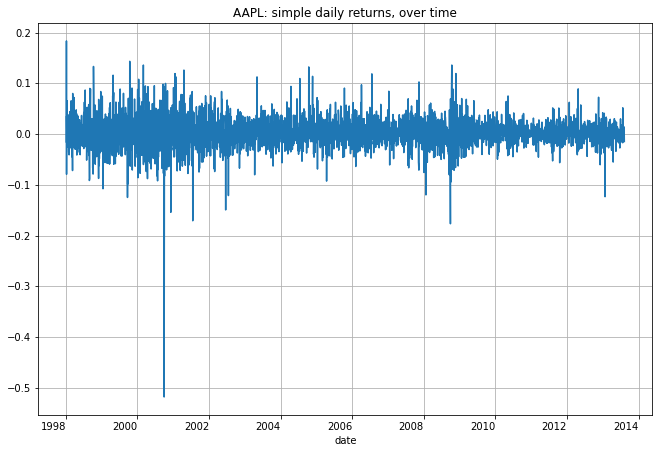

In [15]:
ax = aapl_df.return_daily.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: simple daily returns, over time")

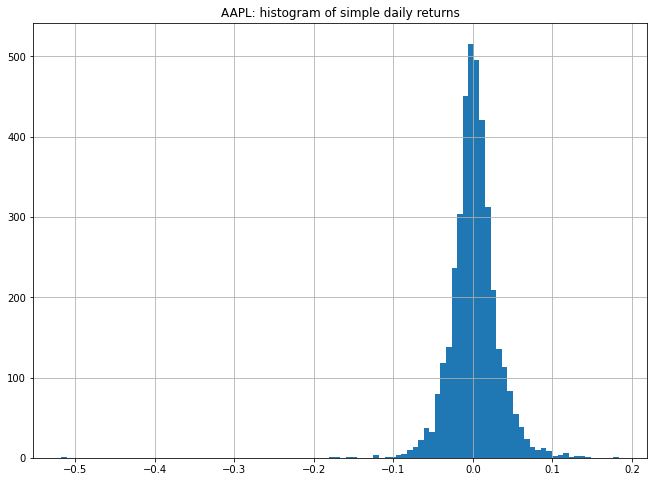

In [16]:
ax = aapl_df.return_daily.hist(bins=100, figsize=(11, 8))
g = ax.grid(True)
t = ax.title.set_text("AAPL: histogram of simple daily returns")

### Autocorrelation

An important component of time series analysis and forecasting is that of checking for _autocorrelation_, or the correlation between a time series and previous versions of itself. This can be helpful in figuring out how to model a given time series.

In [17]:
aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(1).rename("t-1")
                   ).corr()

,t,t-1
t,1.000000,-0.034992
t-1,-0.034992,1.000000


### --

### Problem

- get _autocorrelation_ going back through 30 lags
- plot the results - make sure to label your plot

### --

### Multi-Period Returns

The simple return can be written as $$ \large \frac{X_{t} - X_{t - 1}}{X_{t- t}}$$

We can make a small modification to the simple return such that we do not subtract the previous period's value out and instead just take the ratio between current and previous $$ \large \frac{X_{t}}{X_{t- t}}$$

This structure allows us to easily calculate multi-period returns.

### Monthly Returns

In [18]:
aapl_df["year"] = aapl_df.date.dt.year

In [19]:
aapl_df["month"] = aapl_df.date.dt.month

In [20]:
aapl_df["return_daily_gross"] = aapl_df.return_daily + 1

In [21]:
aapl_df.head()

,date,open,high,low_price,close,volume,return_daily,year,month,return_daily_gross
date,,,,,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10,NaN,1998,1,NaN
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08,-0.015384,1998,1,0.984616
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55,0.183749,1998,1,1.183749
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52,-0.079196,1998,1,0.920804
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95,0.035552,1998,1,1.035552


In [22]:
aapl_monthly = aapl_df.groupby(["year", "month"]).return_daily_gross.prod()

In [23]:
aapl_monthly.shape

(188,)

In [24]:
aapl_monthly = aapl_monthly.rename("return_t")

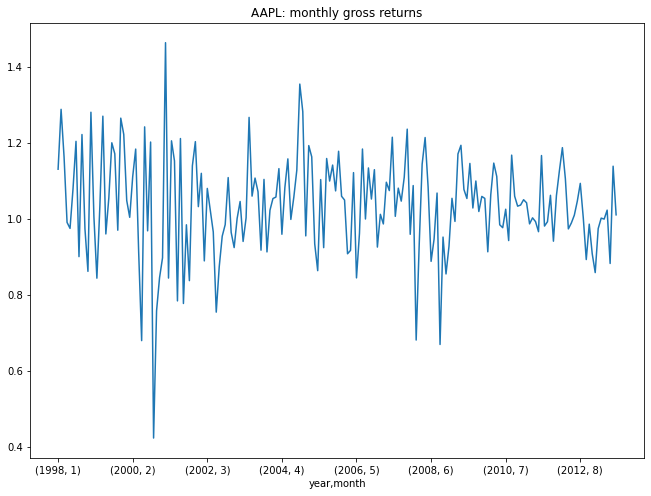

In [25]:
ax = aapl_monthly.plot(figsize=(11, 8))
t = ax.set_title("AAPL: monthly gross returns")

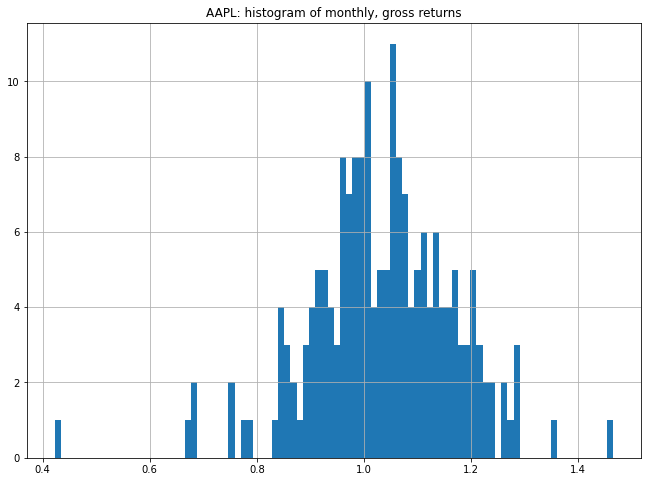

In [26]:
ax = aapl_monthly.hist(bins=90, figsize=(11, 8))
t = ax.title.set_text("AAPL: histogram of monthly, gross returns")

In [27]:
aapl_monthly = aapl_monthly.to_frame()

### Rolling

Using the `rolling` method, we can create a rolling window of variable lengths over our data, and we can apply different sorts of aggregations.

#### Cumulative

Instead of limiting ourselves to the confines of a particular month, we can look at our returns over the last 21 or so days (there are typically about 21 trading days in a month).

In [28]:
aapl_df["return_cumulative_21_day"] = aapl_df.return_daily_gross.dropna().rolling(21).apply(np.prod, raw=True) - 1

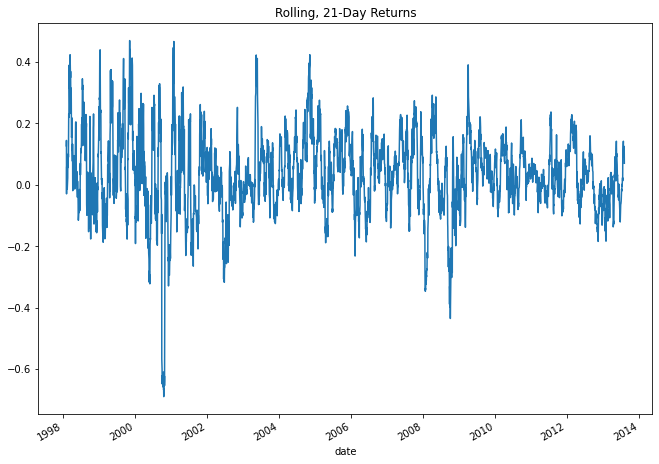

In [29]:
ax = aapl_df.return_cumulative_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Returns")

#### Average

We can also look at average daily return over a rolling period, which can help represent daily movements in a smoother sort of way than looking at the actual daily values.

In [30]:
aapl_df["return_mean_21_day"] = aapl_df.return_daily.rolling(21).mean()

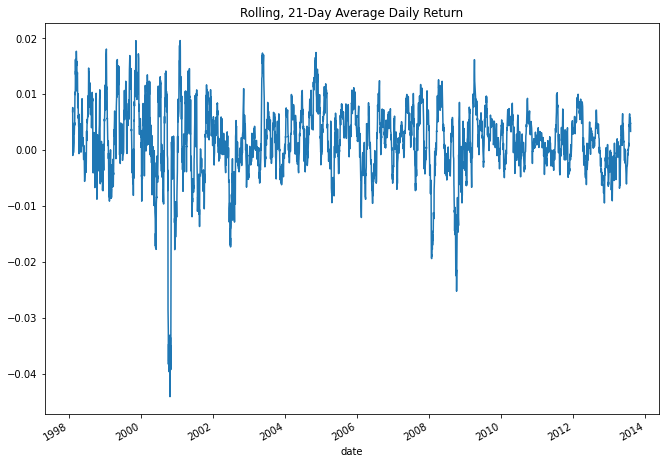

In [31]:
ax = aapl_df.return_mean_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Average Daily Return")

#### Volatility

We can also look at daily volatility.

In [32]:
aapl_df["return_std_21_day"] = aapl_df.return_daily.rolling(21).std()

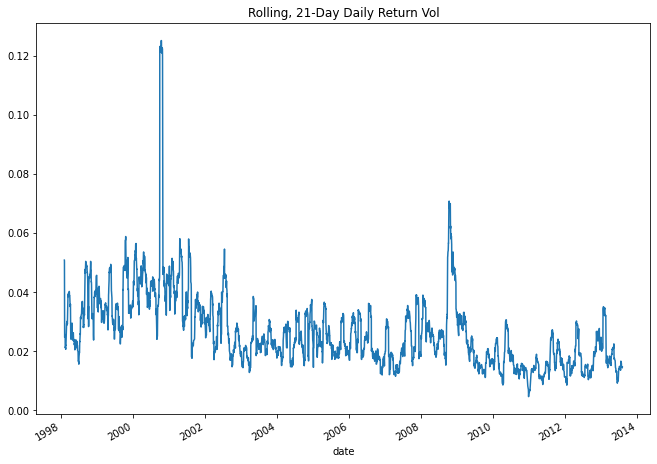

In [33]:
ax = aapl_df.return_std_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Daily Return Vol")

#### Comparisons

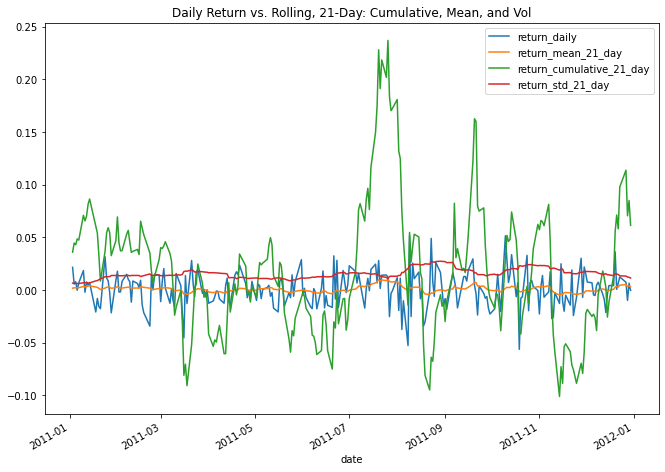

In [34]:
ax = aapl_df.loc[
    aapl_df.year == 2011,
    ["return_daily", "return_mean_21_day", "return_cumulative_21_day", "return_std_21_day"]
            ].plot(figsize=(11, 8))

t = ax.title.set_text("Daily Return vs. Rolling, 21-Day: Cumulative, Mean, and Vol")

### --

### Problem

- write function to get rolling Sharpe ratios, that takes as a parameter the width of the window (in days)
- use this function to get 5, 20, and 60 day series, and plot to compare

### --

### Dummy Variables

Some data is *categorical*, or non-numeric, even if it's ordered. As such, it needs to be *one-hot encoded* - a vector of categorical data becomes a matrix with one `bool` column for each categorical value.

#### Day of the Week

In [35]:
aapl_df["day_of_week"] = aapl_df.date.dt.dayofweek

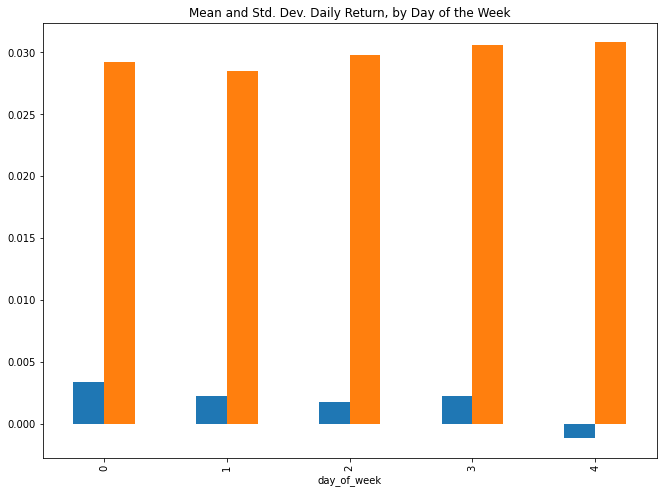

In [36]:
ax = aapl_df[
        ["return_daily", "day_of_week"]
            ].groupby(
        "day_of_week"
            ).agg(
        [np.mean, np.std]
            ).plot.bar(
        figsize=(11, 8))

ax.legend().remove()

t = ax.title.set_text("Mean and Std. Dev. Daily Return, by Day of the Week")

In [37]:
d_o_w = pd.get_dummies(aapl_df.day_of_week, drop_first=True)

Note that `drop_first` means that we don't create a column for the first value, which is in this case `0` (Monday). This is because we don't want redundancy in our features - we already know that a given row represents a Monday if it is not any of Tuesday, Wednesday, Thursday, or Friday.

In [38]:
d_o_w.head()

,1,2,3,4
date,,,,
1998-01-02,0,0,0,1
1998-01-05,0,0,0,0
1998-01-06,1,0,0,0
1998-01-07,0,1,0,0
1998-01-08,0,0,1,0


In [39]:
d_o_w = d_o_w.join(aapl_df.return_daily)

We will regress simple return against day of the week - this provides an additional avenue for quantifying the relationship (and for keeping an eye out for possible features). When modeling time series data, we must *always* remember the train / test split.

In [100]:
train = d_o_w.loc[datetime.date(2012, 1, 1):datetime.date(2012, 11, 30)]

In [101]:
train.shape

(230, 5)

In [102]:
test = d_o_w.loc[datetime.date(2012, 12, 1):datetime.date(2012, 12, 31)]

In [103]:
test.shape

(20, 5)

Simply training on, and then predicting, the same set of data can work for a regression analysis.

For instance, [r squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) is a performance measure that indicates how good of a job a model is doing at "explaining" the variance in the data. It is calculated as:
$$ \large 1 - \frac {\sum {(y - \hat y)^2}}{\sum {(y - \bar y)^2}}$$

This is in simple / one-predictor regression the square of the correlation between predictor and response. In multiple regression, it is the square of the coefficient of multiple correlation. Another way to interpret this measure is as the improvement over the performance of simply using the mean of the training data for making future predictions. So, regression analysis provides a handy and interpretable route for evaluating relationship strength.

When thinking about the performance estimation, however, you must **always** train on data that comes *before* your test data.

In [44]:
reg = LinearRegression()

In [45]:
reg = reg.fit(train.iloc[:, :4], train.return_daily)

In [46]:
reg.score(train.iloc[:, :4], train.return_daily)

0.03890481494263098

In [47]:
reg.score(test.iloc[:, :4], test.return_daily)

0.00813138843177097

### --

### Problem

- perform similar analyses for `month` and `quarter`
- feel free to experiment with the time window / testing methodology

### --

### Transformations

Sometimes, we might transform data in one way on another so as to change certain properties of the data.

For instance, a _log_ or _square-root_ transform will reduce skewness in a continuous variable - such a reduction can help bring the data closer to the underlying assumptions for a given modeling framework, which can improve prediction results. You can read more on that [here](https://otexts.com/fpp2/transformations.html).

Something often talked about in finance is _log-normal distribution of prices_, which we'll take a quick look at.

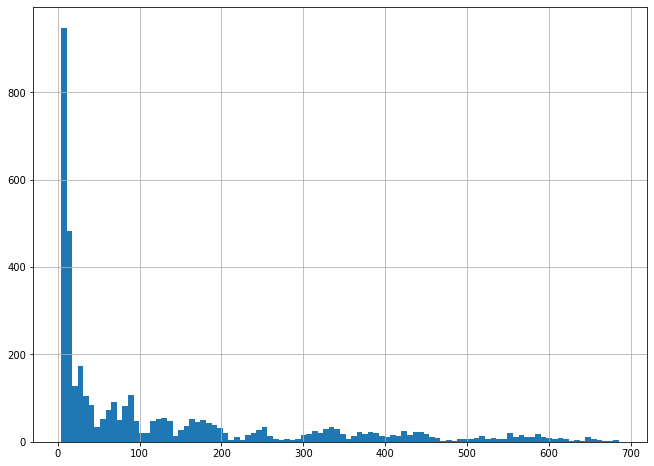

In [48]:
aapl_df.close.hist(figsize=(11, 8), bins=100)

t = ax.title.set_text("Histogram: Closing Prices")

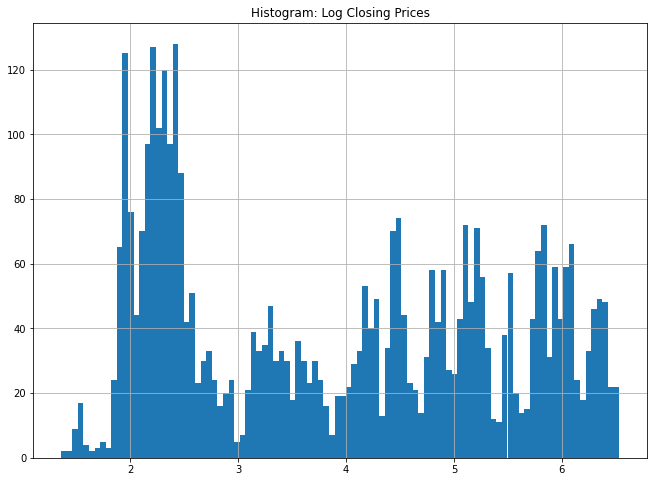

In [49]:
ax = aapl_df.close.apply(np.log).hist(figsize=(11, 8), bins=100)

t = ax.title.set_text("Histogram: Log Closing Prices")

If the prices were truly log-normal, we would see _normal_ log-returns, which is not the case. Note that skewness, however, has been reduced greatly. To get log-returns, we simply take the difference between the log-price values:

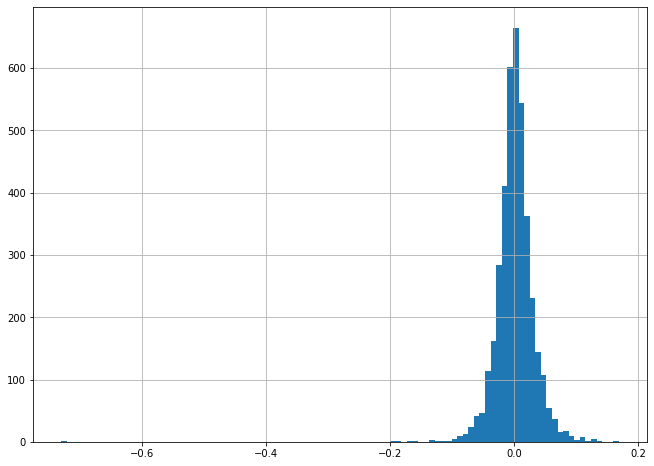

In [50]:
aapl_df.close.apply(np.log).diff().hist(figsize=(11, 8), bins=100)

t = ax.title.set_text("Histogram: Log Returns")

# 2. First Pass at Predictive Modeling

### Classical Time Series Models

The gist of time-series modeling is that, practically speaking, you use previous values of a dataset to predict future values of it.

For instance, a simple, cross-sectional (i.e. not-time-series) modeling exercise might be to predict housing prices given the square-footage of a house. While you will likely use historical data to train your model, you are using the relevant values of a different variable, square-footage, to predict future prices, rather than using past values of the prices themselves. Whereas, if you looked at both square footage _and_ previous sale prices as input variables, this would be a real time series model.

Using previous response values as predictor variables is known as _autoregression_ (i.e. regressing something against iteself) and the classic _AR_ [model](https://en.wikipedia.org/wiki/Autoregressive_model) provides an estimate of future values through taking the dot product of weights and the previous values of the data that they correspond to. You can fit an AR model with ordinary least squares (OLS).

The _autoregressive moving average model_ (ARMA) takes this further, and also [includes](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) term(s) corresponding to moving / rolling averages over prior pieces of the data. One method for choosing how many lagged and MA terms to include is by looking at something called a [partial autocorrelation function](https://en.wikipedia.org/wiki/Partial_autocorrelation_function).

There are additional, "classical" variations on the basic framework that account for potential flaws in the underlying assumptions of these models. We are not really going to adhere to a classical statistics framework here but we will draw on some of the core ideas of these models as we work to, in a more "machine-learning" sort of way, engineer our own solutions.

### Basic / Benchmark Models

It's important to always have an underlying sense of what your benchmark / default might be when modeling - you never want to think about your predictions as if they exist in some sort of vacuum. We will start with a couple of basic, dummy models to test.

Note that these will work terribly on the data we're working with - stocks are hard to predict, and using one only one month for testing is not a good approach for really validating a model. There are plenty of time series datasets for which doing something really simple will yield better results.

In [104]:
train = train.return_daily

In [105]:
test = test.return_daily

#### Average

In [53]:
model = lambda: train.mean()

In [54]:
model()

0.0017979570942215008

In [55]:
y_pred = pd.Series([model() for _ in range(test.shape[0])], index=test.index)

In [56]:
r2_score(test, y_pred)

-0.07597763639405897

In [57]:
y_pred

date
2012-12-03    0.001798
2012-12-04    0.001798
2012-12-05    0.001798
2012-12-06    0.001798
2012-12-07    0.001798
2012-12-10    0.001798
2012-12-11    0.001798
2012-12-12    0.001798
2012-12-13    0.001798
2012-12-14    0.001798
2012-12-17    0.001798
2012-12-18    0.001798
2012-12-19    0.001798
2012-12-20    0.001798
2012-12-21    0.001798
2012-12-24    0.001798
2012-12-26    0.001798
2012-12-27    0.001798
2012-12-28    0.001798
2012-12-31    0.001798
dtype: float64

#### Naive

In [58]:
r2_score(test.iloc[1:], test.shift(1).iloc[1:])

-1.0085314567136514

### Partial Autocorrelation

With _partial autocorrelation_, we look seek to identify the autocorrelation that is unique to a particular lag - i.e. we control for the autocorrelation of other lagged variables. You can read more on that [here](https://towardsdatascience.com/understanding-partial-auto-correlation-fa39271146ac). This can be a nice method for identifying useful lags for modeling.

In [59]:
partial_auto = pd.Series(pacf(aapl_df.return_daily.dropna(), nlags=90))

In [60]:
partial_auto.index.name = "lags"

In [61]:
partial_auto = partial_auto.iloc[1:]

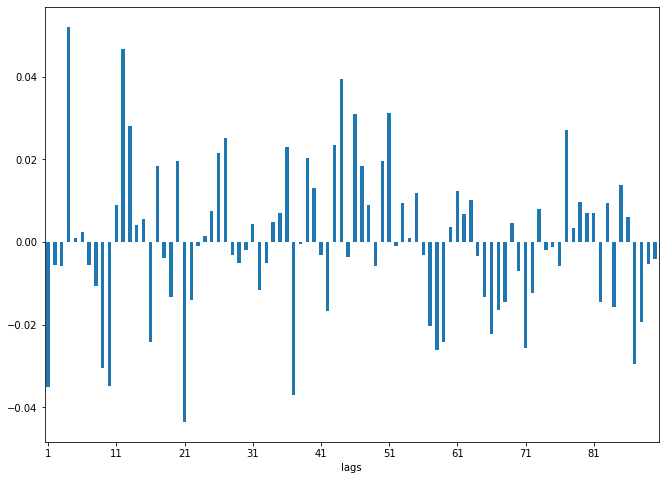

In [62]:
ax = partial_auto.plot.bar(figsize=(11, 8), rot=0)
plt.locator_params(nbins=9)
xlab = ax.set_xticklabels((1, 11, 21, 31, 41, 51, 61, 71, 81, 91))

In [63]:
partial_auto.abs().sort_values(ascending=False)[:10]

lags
4     0.052106
12    0.046723
21    0.043522
44    0.039513
37    0.036973
1     0.034998
10    0.034851
51    0.031274
46    0.030994
9     0.030490
dtype: float64

In [64]:
to_keep = partial_auto.abs().sort_values(ascending=False)[:10].index

### Feature Engineering

Let's write some functionality to help us create lagged variables.

In [65]:
def get_shifted_feature(srs, shift_num):
    return srs.shift(shift_num)

In [66]:
def get_shifted(srs, shift_nums_list):
    """
    Returns a df, with each column corresponding to `srs` being shifted,
    for each num in `shift_nums_list`.
    """
    return pd.concat([
                        get_shifted_feature(srs, i).rename(f"{srs.name}_shifted_{i}")
                        for i in shift_nums_list
            ], axis=1)

In [114]:
aapl_features = get_shifted(aapl_df.return_daily, to_keep)

In [115]:
aapl_features.shape

(3926, 10)

In [116]:
aapl_features.head().T

date,1998-01-02,1998-01-05,1998-01-06,1998-01-07,1998-01-08
return_daily_shifted_4,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_12,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_21,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_44,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_37,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_1,NaN,NaN,-0.015384,0.183749,-0.079196
return_daily_shifted_10,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_51,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_46,NaN,NaN,NaN,NaN,NaN
return_daily_shifted_9,NaN,NaN,NaN,NaN,NaN


Note that we shift our rolling features back when joining:

In [117]:
aapl_features = aapl_features.join(
                    aapl_df[[
                        "return_mean_21_day",
                        "return_cumulative_21_day",
                        "return_std_21_day"
                    ]].shift(1))

In [118]:
aapl_features.shape

(3926, 13)

Let's grab our `d_o_w` features from before, and run on the same *train / test* split:

In [119]:
train = d_o_w.loc[datetime.date(2012, 1, 1):datetime.date(2012, 11, 30)]

In [120]:
train = train.join(aapl_features, how="left")

In [121]:
test = d_o_w.loc[datetime.date(2012, 12, 1):datetime.date(2012, 12, 31)]

In [122]:
test = test.join(aapl_features, how="left")

In [123]:
train.columns

Index([                         1,                          2,
                                3,                          4,
                   'return_daily',   'return_daily_shifted_4',
        'return_daily_shifted_12',  'return_daily_shifted_21',
        'return_daily_shifted_44',  'return_daily_shifted_37',
         'return_daily_shifted_1',  'return_daily_shifted_10',
        'return_daily_shifted_51',  'return_daily_shifted_46',
         'return_daily_shifted_9',       'return_mean_21_day',
       'return_cumulative_21_day',        'return_std_21_day'],
      dtype='object')

In [124]:
X_cols = [c for c in train.columns if c != "return_daily"]

In [125]:
X_train = train.loc[:, X_cols]

In [126]:
y_train = train.loc[:, "return_daily"]

In [127]:
X_test = test.loc[:, X_cols]

In [128]:
y_test = test.loc[:, "return_daily"]

### Additional Prep

In [129]:
X_train.dtypes.value_counts()

float64    13
uint8       4
dtype: int64

We are going to standardize the float columns such that the data has a mean of 0 and standard deviation of 1, which will help our model's performance. Note that we do this separately for train and test data so as to avoid data leakage:

In [134]:
scaler = StandardScaler()

In [135]:
float_cols = X_train.select_dtypes(include=float).columns

In [136]:
X_train.loc[:, float_cols] = scaler.fit_transform(X_train.loc[:, float_cols])

In [137]:
X_train.loc[:, float_cols].mean()

return_daily_shifted_4     -2.992775e-17
return_daily_shifted_12     3.897848e-17
return_daily_shifted_21     9.654113e-19
return_daily_shifted_44     1.110223e-17
return_daily_shifted_37    -1.544658e-17
return_daily_shifted_1     -8.205996e-18
return_daily_shifted_10    -2.896234e-17
return_daily_shifted_51     2.075634e-17
return_daily_shifted_46    -1.158494e-17
return_daily_shifted_9      2.762736e-17
return_mean_21_day          9.171408e-17
return_cumulative_21_day    7.095773e-17
return_std_21_day          -9.654113e-19
dtype: float64

In [138]:
X_train.loc[:, float_cols].std()

return_daily_shifted_4      1.002181
return_daily_shifted_12     1.002181
return_daily_shifted_21     1.002181
return_daily_shifted_44     1.002181
return_daily_shifted_37     1.002181
return_daily_shifted_1      1.002181
return_daily_shifted_10     1.002181
return_daily_shifted_51     1.002181
return_daily_shifted_46     1.002181
return_daily_shifted_9      1.002181
return_mean_21_day          1.002181
return_cumulative_21_day    1.002181
return_std_21_day           1.002181
dtype: float64

In [139]:
X_test.loc[:, float_cols] = scaler.fit_transform(X_test.loc[:, float_cols])

### `LinearRegression` 

In [140]:
linreg = LinearRegression()

In [141]:
linreg = linreg.fit(X_train, y_train)

In [142]:
linreg.score(X_train, y_train)

0.10344269545067508

Ok, we've seen a definite improvement over just taking the mean of the data - but this is only on train, so what about on the (more important) test set?

In [143]:
linreg.score(X_test, y_test)

-0.11943049993924104

Much worse! The large gap between train and test performance exemplifies what's known as *overfitting* - the model is too tightly coupled to the training data to be able to generalize to new data well.

### `Ridge` 
- in *Ridge regression*, something called *L2 normalization* is applied
- [this](https://en.wikipedia.org/wiki/Tikhonov_regularization) will force coefficients to stay close to 0, which helps to prevent overfitting
- in `sklearn`, we control this value with the `alpha` hyper parameter
- the higher the value of `alpha`, the higher the regularization; tuning in powers of ten is common

In [152]:
ridge = Ridge(alpha=10**3)

In [153]:
ridge = ridge.fit(X_train, y_train)

In [154]:
ridge.score(X_train, y_train)

0.028450632342061133

In [155]:
ridge.score(X_test, y_test)

-0.11015771934750629

So, what did we do here? We brought down the performance of our train performance a bit, and brought up up our test performance - that's good, right? Well, the problem is that we brought down our train performance a lot more than we brought our test performance up by. Predicting stocks is hard!

### Visualize Predictions

In [156]:
y_test_pred = ridge.predict(X_test)

In [157]:
y_test = y_test.rename("y_test").to_frame()

In [158]:
y_test["y_pred"] = y_test_pred

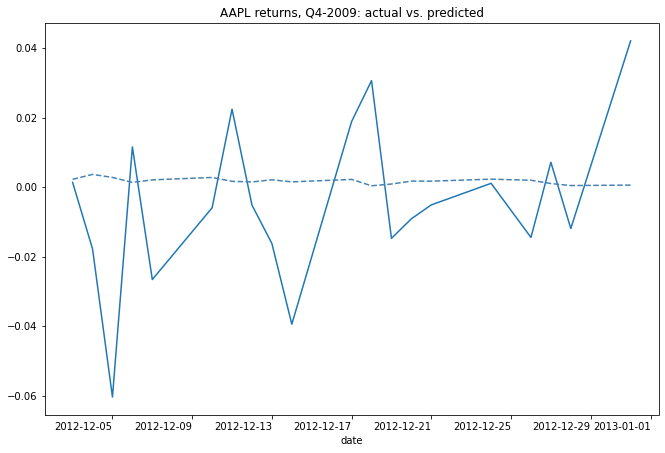

In [159]:
ax = y_test.y_test.plot(figsize=(11, 8), rot=0)
ax = y_test.y_pred.plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, Q4-2009: actual vs. predicted")

In [160]:
y_test.head()

,y_test,y_pred
date,,
2012-12-03,0.001420,0.002292
2012-12-04,-0.017719,0.003712
2012-12-05,-0.060336,0.002834
2012-12-06,0.011614,0.001413
2012-12-07,-0.026545,0.002133


Our model's results are waaayyy smoother than the actual trade moves are - those multi-point daily moves are volatile! In trying to diagnose what's going on so that we can make this better, an important observation is that we're only testing on one month - maybe December is particularly volatile?

Even if our model was doing well here, this is not a robust way to validate a model - we need to try out out over a number of different periods.

# 3. Walk-Forward Validation

Just as in cross-sectional modeling, where *cross validation* is used, we want unbiased estimations of model performance. In time-series modeling, however, we need to be very careful not to leak data, which can be easy to do when there is a strict chronology. So, we run train / test splits over different parts of the data, where train _always_ comes before test.

We can (and sometimes, should) make things more complicated when there's a lot of model tuning, feature selection, etc. happening, but a general workflow is:

- take some subset of the rows in the data
- train over the first *X%* of that data, and predict the rest
- record results, and then slide the test portion out further and repeat
- the whole train / test window can be slid forward, or just the test portion
- which to choose depends on the problem: is more training data always helpful, or does the process fundamentally change, e.g., each year?
- report the mean and standard deviation performance across all trials
- and, drill down into the areas where the model did particularly well, or particularly poorly

### --

### Problem

Write a program to perform walk-forward validation. We will go on to use this program to help us in our modeling decisions, i.e. in selecting features to use, hyper-parameter values to set, etc.

The program should take in the following parameters:

- `model_obj` (already instantiated)
- `X`
- `y`
- `start_date`
- `trial_width`
- `test_width`
- `num_trials`

And should do the following:
- for each of `num_trials`, cut out a chunk of data `trial_width` wide and divide it into train / test
- fit the model to train, and predict test
- save the actual and prediction results into a dictionary
- save that dictionary into a list

Assume widths are all in `"days"` to make things easier. And, you can start with a `start_date` of `datetime.date(2010, 1, 1)`.

In [168]:
aapl_features = aapl_features.join(d_o_w)

In [ ]:
def time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials):
    
    results = []
    
    for i in range(num_trials):
        trial = {}
        # end_date = start_date + datetime.timedelta(days=trial_width)
        # now, get train and test boundaries
        # split X and y into X_train, y_train, X_test, y_test based on train and test boundaries
        # train the model
        # predict X_test, and save results:
        trial["y_pred"] = y_pred
        # save actual data:
        trial["y_test"] = y_test
        # save trial results
        results.append(trial)
        # now, bump start_date forward by test_width

# 4. Beat My *R-Squared*

Experiment with different feature sets, and model parameters to try to outperform my solution. Feel free to change the problem up - what about predicting monthly returns.